**Project 1**

Dataset: Oakland Airbnb dataset

**Motivation:**

For this project, I was interested in exploring the Airbnb dataset from Oakland to better understand the following questions:

1.   What we can say about customer’s feelings in the reviews posted after staying in an Airbnb Oakland house/apartment?
2.   What is the sentiment analysis of customer review grouped by neighborhood?
3.   Which topics were most commented on in the customer review? Listed the words for each *topic*

**Blog Link:**

https://medium.com/@mayrazrodriguez/sentiment-analysis-and-topic-modeling-using-airbnb-dataset-c65848b98a57?source=friends_link&sk=3f85f6c3093b8a3981fd2197da189d37





we import the packages that we will use throughout the project.

In [82]:
import pandas as pd
import io
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re
from nltk.stem import PorterStemmer
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Load the dataset from google colab

In [6]:
from google.colab import files
uploaded = files.upload()

Saving listings.csv to listings.csv
Saving reviews.csv to reviews.csv


In [10]:
reviews = pd.read_csv(io.BytesIO(uploaded['reviews.csv']))
print("Number of rows in data =",reviews.shape[0])
print("Number of columns in data =",reviews.shape[1])

Number of rows in data = 107468
Number of columns in data = 6


In [11]:
listings = pd.read_csv(io.BytesIO(uploaded['listings.csv']))
print("Number of rows in data =",listings.shape[0])
print("Number of columns in data =",listings.shape[1])

Number of rows in data = 3211
Number of columns in data = 106


The class CleanUp contain the merge_csv method that will be used to extract the neighborhood attribute and join to listings dataset.
The clean_dataset and patterns method was used to remove punctuations, NA values.
The remove_stop_words method was used to remove stop words and additional words.

In [0]:
class CleanUp():
    def __init__(self):
        self.review = pd.read_csv(io.BytesIO(uploaded['reviews.csv']))
        self.listings = pd.read_csv(io.BytesIO(uploaded['listings.csv']))

    def build(self):
        data = self.merge_csv()
        clean_data = self.clean_dataset(data)
        data_without_stop_word = self.remove_stopwords(clean_data)
        data_without_stop_word['comments'] = data_without_stop_word['comments'].apply(self.lemmatize_text)
        print('Finished cleaning process')
        return clean_data, data_without_stop_word

    def merge_csv(self):
        listings_data = self.listings
        tmp_listings_data = listings_data.loc[:, ['id', 'neighbourhood']]
        reviews_data = self.review
        merged_dataframe = pd.merge(left=reviews_data,right=tmp_listings_data, \
                                    how='left', left_on='listing_id', right_on='id')
        return merged_dataframe

    def patterns(self, text):
        text = re.sub('[^a-zA-Z0-9_.+-]+', ' ', text)
        text = text.strip(' ')
        return text

    def clean_dataset(self, data):
        data.columns = map(str.lower, data.columns)
        data.drop(columns=['id_y'], inplace=True)
        # removing NA from column comments
        data.dropna(subset=['comments'], axis=0, inplace=True)
        # removing everything except alphabets`
        #data['comments'] = data['comments'].map(lambda text : self.patterns(text))
        data['comments'] = data['comments'].str.replace("[^A-Za-z0-9]", " ")
        data['comments'] = data['comments'].str.replace('\d+', '')
        data['comments'] = data['comments'].str.replace('[^\w\s]', '')
        data['comments'] = \
            data['comments'].str.split().map(lambda sl: " ".join(s for s in sl if len(s) > 2))
        # remove extra white spaces
        data['comments'] = data['comments'].replace('\s+', ' ', regex=True)

        return data

    def lemmatize_text(self, text):
        lemma = WordNetLemmatizer()
        return [lemma.lemmatize(w) for w in word_tokenize(text)]

    def remove_stopwords(self, data):

        stop_words = stopwords.words('english')
        additional_stopwords = ['would','could', 'will', 'francisco','lauren','kevin', 'can', 'may', 'might', 'must',
                                'and', 'i', 'a', 'and', 'so', 'arnt', 'this', 'when', 'did',  'there', 'street',
                                'all', 'front', 'there', 'traci', 'jon', 'jasmine', 'kerry', 'jarrett', 'steve',
                                'abiel', 'moreover','zoe','every']
        stop_words.extend(additional_stopwords)

        data['comments'] = \
            data['comments'].str.split().map(lambda sl: " ".join(s for s in sl if len(s) > 4))

        data['comments'] = data['comments'].replace('\s+', ' ', regex=True)

        data.dropna(subset=['comments'], axis=0, inplace=True)

        data.loc[:, 'comments'] = data['comments'].apply(
            lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

        data['comments'] = data['comments'].str.strip()
        return data

In [167]:
preprocess_obj = CleanUp()
clean_data, data_without_stop_word = preprocess_obj.build()

Finished cleaning process


The steam_word method in AnalysisData class aims to perform the steam process and the score_sentimental method calculates the polarity score of each word.

In [0]:
class AnalysisData():
    def __init__(self):
      pass
    def score_sentimental(self, clean_data):
        output_data = self.steam_word(clean_data)
        polarity_score_list = [round(TextBlob(word).polarity,1) for word in output_data['comments']]
        clean_data['polarity_score'] = polarity_score_list
        clean_data['label_polarity'] = 'neutral'
        clean_data.loc[clean_data[clean_data['polarity_score'] == 0].index, ['label_polarity']] = 'neutral'
        clean_data.loc[clean_data[(clean_data['polarity_score'] > 0) & (clean_data['polarity_score'] < 0.6)].index,
                 ['label_polarity']] = 'positive'
        clean_data.loc[clean_data[(clean_data['polarity_score'] >= 0.6) & (clean_data['polarity_score'] <= 1.0)].index,
                 ['label_polarity']] = 'highly positive'
        clean_data.loc[clean_data[(clean_data['polarity_score'] < 0) & (clean_data['polarity_score'] > -0.6)].index,
                 ['label_polarity']] = 'negative'
        array_polarity_score = np.unique(polarity_score_list, return_counts=True)
        neighborhood_df = clean_data[['polarity_score', 'neighbourhood']].groupby(['neighbourhood']).agg(['mean', 'count'])
        neighborhood_df.columns = neighborhood_df.columns.droplevel(0)
        print('Finished the polarity analysis')
        return array_polarity_score, neighborhood_df, output_data
  
    def steam_word(self,data):
      #data.dropna(subset=['comments'], axis=0, inplace=True)
      data['comments']=data['comments'].apply(str)
      porter = PorterStemmer()
      data.loc[:, 'comments'] = data['comments'].apply(
          lambda x: ' '.join([porter.stem(word) for word in word_tokenize(x)]))
      return data

The GetTopic class infers the topic of a text

In [0]:
class GetTopic():
    def __init__(self, data_without_stop_word):
        self.n_topics = 4
        self.num_words_topic = 25
        self.df = data_without_stop_word
        self.df.dropna(subset=['comments'], axis=0, inplace=True)
        self.num_rows = self.df['comments'].size

    def execute_lda_model(self):
        from sklearn.decomposition import LatentDirichletAllocation
        from sklearn.feature_extraction.text import CountVectorizer
        # the vectorizer object will be used to transform text to vector form
        vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')
        # apply transformation
        tf = vectorizer.fit_transform(self.df['comments'])
        # tf_feature_names tells us what word each column in the matric represents
        tf_feature_names = vectorizer.get_feature_names()
        number_of_topics = self.n_topics
        model = LatentDirichletAllocation(batch_size=128,
                        n_components=number_of_topics, learning_method='online',
                       random_state=0).fit(tf)
        print('Finished the extract topic step')
        return tf_feature_names, model, self.n_topics
        #self.display_topics(model, tf_feature_names)

    def display_topics(self, model, feature_names):
        no_top_words = self.num_words_topic
        ntopics = self.n_topics
        topic_dict = {}
        for topic_idx, topic in enumerate(model.components_):
            topic_dict["Topic %d words" % (topic_idx)] = ['{}'.format(feature_names[i])
                                                          for i in topic.argsort()[:-no_top_words - 1:-1]]
            topic_dict["Topic %d weights" % (topic_idx)] = ['{:.1f}'.format(topic[i])
                                                            for i in topic.argsort()[:-no_top_words - 1:-1]]
     

The PlotModel class contains all methods that plot results

In [0]:
class PlotModel():
    def __init__(self):
        pass

    def review_polarity_level(self, data):
        plt.figure(figsize=(8, 4))
        ax = data['label_polarity'].value_counts().plot(kind='bar',color="indianred")
        ax.set_xlabel("polarity level", fontsize=12)
        ax.set_ylabel("count", fontsize=12)
        plt.show()

    def review_polarity(self, array_polarity_score):
        plt.figure(figsize=(8, 4))
        ax = sns.barplot(array_polarity_score[0], array_polarity_score[1], color="salmon", saturation=.5, label='Boston')
        ax.set_xlabel('Airbnb review', fontsize=14)
        ax.set_ylabel('Number of reviews', fontsize=14)
        plt.show()


    def review_neighborhood(self, neighborhood_df):
        ax = neighborhood_df[['mean']].plot.bar(figsize=(10, 6), legend=False, fontsize=6)
        ax.set_xlabel("Neighbourhood", fontsize=10)
        ax.set_ylabel("Average polarity score", fontsize=10)
        plt.show()
        ax = neighborhood_df[['count']].plot.bar(figsize=(10, 6), legend=False, fontsize=6)
        ax.set_xlabel("Neighbourhood", fontsize=10)
        ax.set_ylabel("Number of review", fontsize=10)
        plt.show()

    def show_topic_classification(self, feature_names, model,ntopics):
        fig = plt.figure()
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        for j in range(0, ntopics):
            topic = model.components_[j]
            topic_words = [feature_names[i] for i in topic.argsort()[:-25 - 1:-1]]
            topic_cloud = WordCloud(
                stopwords=STOPWORDS,
                background_color='black',
                width=4000,
                height=2800
            ).generate(" ".join(topic_words))
            ax = fig.add_subplot(2,2, j+1)
            ax.imshow(topic_cloud)
            ax.axis('off')
        plt.show()

    def show_topics(self, lda):
        plt.figure(figsize=(8, 6))
        num_col = 3
        num_row = 5
        for i in range(15):
            df = pd.DataFrame(lda.show_topic(i), columns=['term', 'prob']).set_index('term')
            plt.subplot(num_row, num_col, i + 1)
            ax = sns.barplot(x='prob', y=df.index, data=df, palette='Blues')
            ax.set_title('topic ' + str(i), fontdict={'fontsize': 8, 'fontweight': 'medium'})
            ax.set_xlabel('probability', fontsize=8)
            ax.set_ylabel('term', fontsize=8)
            ax.tick_params(axis="y", labelsize=8)
            ax.tick_params(axis="x", labelsize=8)
        plt.show()

In [162]:
analysis_obj = AnalysisData()
array_polarity, neigh_df, output_data = analysis_obj.score_sentimental(clean_data)


Finished the polarity analysis


Was created an instance of the PlotModel class where we can access the class methods review_polarity, review_neighborhood and show_topic_classification.

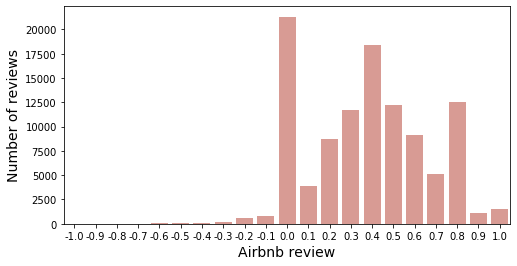

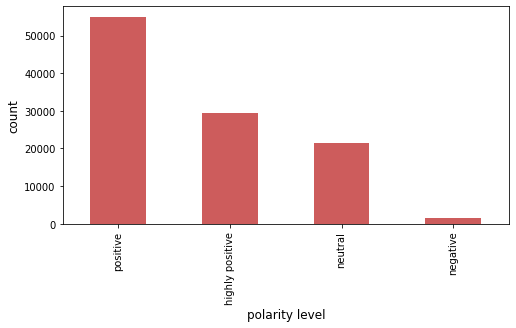

In [165]:
handle_plot = PlotModel()
handle_plot.review_polarity(array_polarity)
handle_plot.review_polarity_level(output_data)

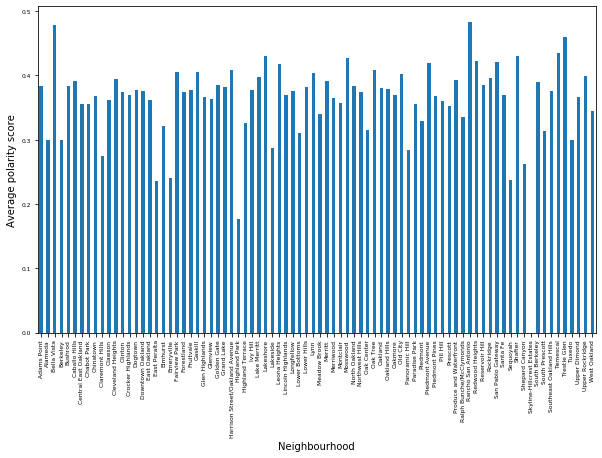

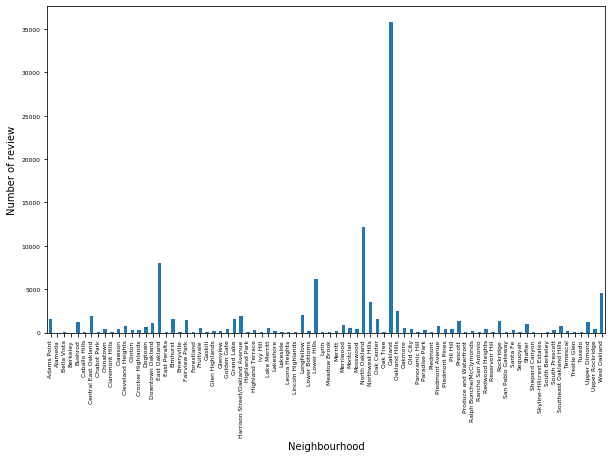

In [171]:
handle_plot.review_neighborhood(neigh_df)